In [1]:
#Mackenzie James
#Homework 5
#Due 2/20/2020- Extended to 2/24/2020
#worked with: Madison Walder, Cassie Bodin, Ryan Webster, Sean Cunningham, Jimmy Lilly, Sammie Mackie

#importing modules needed
from ReadFile import Read
from CenterOfMass import CenterOfMass
from astropy.constants import G
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

## Parts 1-7: Defining Functions

In [2]:
class MassProfile:
    
    #initializing a class based on snapshot number and galaxy name
    def __init__(self,galaxy,snap):
    #inputs: 
        #galaxy- a string with a galaxy name- MW, M31, or M33
        #snap- snapshot number (ex: 0,1...)
    #returns:
        #sets indicies
        
        #reconstructing the filenames
        #add a string of the filenumber to the value "000"
        ilbl = '000' + str(snap)
        #remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'
        
        #read data from user given file (detailed in galaxy above)
        self.time,self.total,self.data=Read(self.filename)
        
        #name of the galaxy
        self.gname=galaxy 
    
    
    #function that will compute the mass enclosed within a given radius in
    #a specific galaxy and a specific particle type
    def MassEnclosed(self,particletype,radii):
    #inputs: 
        #particle type: 1.0=halo, 2.0=disk, 3.0=bulge
        #radii: an array of radii, defined before the function
    #returns:
        #an array of mass enclosed at the different radii (units: Msun)
        
    
        #determine the COM Position, only using type 2 for particles
        #create an instance of class
        COM = CenterOfMass(self.filename, 2)
        COMP = COM.COM_P(0.1)
        
        #creates an array with the user specified particle type
        self.index = np.where(self.data['type']==particletype)
    
        #mass
        self.m = self.data['m'][self.index]
        #x,y,z position
        self.x = self.data['x'][self.index]*u.kpc
        self.y = self.data['y'][self.index]*u.kpc
        self.z = self.data['z'][self.index]*u.kpc
    
        #initialize the array of masses- length of the array of radii defined above
        mass = np.zeros(len(radii))
        
        #find the component distance of a particle from the center of mass
        Xpart = self.x-COMP[0]
        Ypart = self.y-COMP[1]
        Zpart = self.z-COMP[2]
        #find the total distance magnitude of a particle from the center of mass
        Rpart = np.sqrt((Xpart**2)+(Ypart**2)+(Zpart**2))

        #looping over the radius array to get mass enclosed.
        for i in range(len(radii)):
            dist =np.where(Rpart <= radii[i])
            EnclosedMass = self.m[dist]
            mass[i] = np.sum(EnclosedMass)
    
        #return the array in units of Msun
        return mass*1e10*u.Msun
    
    
    
    #function that gives the total enclosed mass
    def MassEnclosedTotal(self,radii):
    #inputs:
        #radii: a previously defined array
    #returns:
        #an array of masses representing the total enclosed mass at each radius
        
        #seperating by galaxy because M33 has no bulge
        if self.gname == "M33":
            halo = self.MassEnclosed(1,r)
            disk = self.MassEnclosed(2,r)
            bulge = 0
        else:
            halo = self.MassEnclosed(1,r)
            disk = self.MassEnclosed(2,r)
            bulge = self.MassEnclosed(3,r)
        
        #summing up all of enlcosed mass calculated in previous function
        MassTot = halo + disk + bulge
        
        return MassTot*u.Msun
        
    
    
    #function that will compute the mass enclosed in a radius using theoretical hernquit profile
    def HernquistMass(self,radii,a,Mhalo):
    #inputs:
        #radius: the distance from the center of the galaxy- given as array (units: kpc)
        #a: scale factor
        #Mhalo: halo mass (units:Msun)
    #returns:
        #total dark matter mass enclosed within r (units: Msun)
        
        #initialize array for hernquist mass at different radii values
        Hmass = np.zeros(len(radii))
        
        for i in range(len(radii)):
            Hmass[i] = Mhalo*radii[i]**2/(a+radii[i])**2
            
        return np.round(Hmass,2)*1e12*u.Msun
    
    
    #Finds the circular velocity for a particle at a given radius in the galaxy
    def CircularVelocity(self,particletype,radii):
    #inputs:
        #particletype: 1.0=halo, 2.0=disk, 3.0=bulge
        #radii: array of radii defined before (units: kpc)
    #return:
        #array of circular speeds (units: km/s)
        
        #storing constant G in correct units
        Gc = G.to(u.kpc*u.km**2/u.s**2/u.Msun) #Gravitational Constant to get V in Km/s
        #radius array (given)
        R = radii
        #array of mass enclosed of a certain particle type at a specific radius
        M = self.MassEnclosed(particletype,r)
        
        #equation to calculate circular velocity (sqrt(GM/R))
        Vcirc = np.sqrt((Gc*M)/R)
        
        return Vcirc
    
    
    #Function of the circular velocity at each radii for all particles
    def CircularVelocityTotal(self,radii):
    #inputs:
        #radii: array of radii defined before (units: kpc)
    #return:
        #array of circular speeds (units: km/s)
        
        Gc = G.to(u.kpc*u.km**2/u.s**2/u.Msun) #Gravitational Constant to get V in Km/s
        #radius array (given)
        R = radii
        #array of mass enclosed of all particles at a specific radius
        Mtot = self.MassEnclosedTotal(r) 
        
        VcircTot = np.sqrt((Gc*Mtot)/R)
        
        return VcircTot
    
    
    #function that computes the circular speed using the Hernquist Mass Profile
    def HernquistVCirc(self,radius,a,Mhalo):
    #inputs:
        #radius: the distance from the center of the galaxy (units: kpc)
        #a: scale factor
        #Mhalo: halo mass (units:Msun)
    #returns:
        #the circular speed of the galaxy at a certain radius according to the Hernquist mass profile
        
        #call the hernquist mass from function before 
        MassHern = self.HernquistMass(radius,a,Mhalo)
        
        #find circular velocity
        Gc = G.to(u.kpc*u.km**2/u.s**2/u.Msun) #Gravitational Constant to get V in Km/s
        #radius array (given)
        R = radius
        
        VcircHern = np.sqrt((Gc*MassHern)/R)
        
        return VcircHern
        
        

## Part 8: Plotting the Mass Profile for each Galaxy

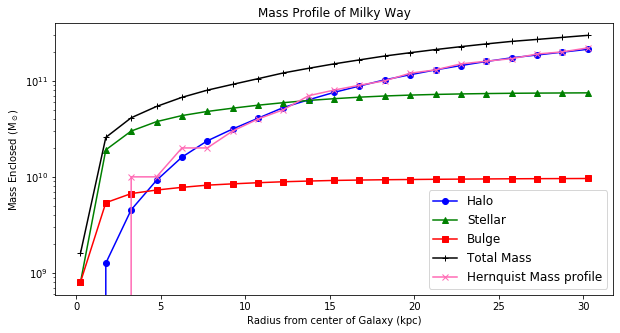

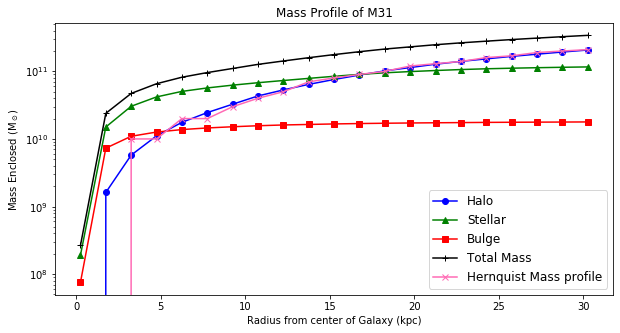

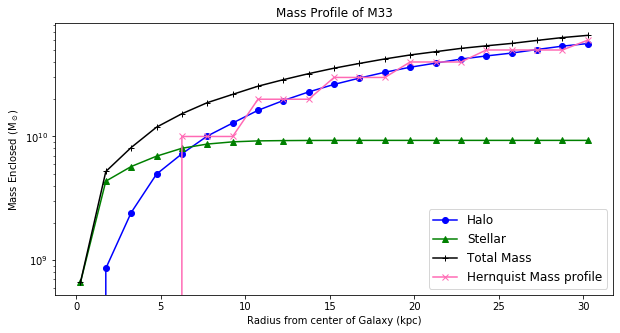

In [5]:
### Milky Way ###

##plot the mass profile of each component -- starting with sample array given

#initailize the class at snapschot 0
MW = MW.MassProfile = MassProfile("MW",0)
#radius array
r = np.arange(0.25,30.5,1.5)*u.kpc
#setting figure size
plt.figure(figsize=(10,5))
#plotting points for the mass enclosed by type of particle
plt.semilogy(r,MW.MassEnclosed(1,r),marker = 'o',color = 'blue',label = 'Halo') #Halo 
plt.semilogy(r,MW.MassEnclosed(2,r),marker = '^',color = 'green',label = 'Stellar') #stellar
plt.semilogy(r,MW.MassEnclosed(3,r),marker = 's',color = 'red',label = 'Bulge') #bulge
#plotting points for the total mass enclosed
plt.semilogy(r,MW.MassEnclosedTotal(r),marker = '+', color = 'black', label = 'Total Mass')
#plotting the Hernquist Mass Profile
plt.semilogy(r,MW.HernquistMass(r/u.kpc,61.1,1.97), marker = 'x',color='hotpink',label = 'Hernquist Mass profile')
#labels
plt.xlabel('Radius from center of Galaxy (kpc)')
plt.ylabel('Mass Enclosed (M$_\odot$)')
plt.title('Mass Profile of Milky Way')
# Legend
plt.legend(loc='lower right',fontsize='large')
plt.show()


### M31 ###

#initailize the class at snapschot 0
M31 = M31.MassProfile = MassProfile("M31",0)
#radius array
r = np.arange(0.25,30.5,1.5)*u.kpc
#setting figure size
plt.figure(figsize=(10,5))
#plot points
plt.semilogy(r,M31.MassEnclosed(1,r),marker = 'o',color = 'blue',label = 'Halo') #Halo 
plt.semilogy(r,M31.MassEnclosed(2,r),marker = '^',color = 'green',label = 'Stellar') #stellar
plt.semilogy(r,M31.MassEnclosed(3,r),marker = 's',color = 'red',label = 'Bulge') #bulge
#plotting points for the total mass enclosed
plt.semilogy(r,M31.MassEnclosedTotal(r),marker = '+', color = 'black', label = 'Total Mass')
#plotting for the Hernquist Mass profile
plt.semilogy(r,M31.HernquistMass(r/u.kpc,60.2,1.92), marker = 'x',color='hotpink',label = 'Hernquist Mass profile')
#labels
plt.xlabel('Radius from center of Galaxy (kpc)')
plt.ylabel('Mass Enclosed (M$_\odot$)')
plt.title('Mass Profile of M31')
# Legend
plt.legend(loc='lower right',fontsize='large')

plt.show()


### M33 ###

#initailize the class at snapschot 0
M33 = M33.MassProfile = MassProfile("M33",0)
#radius array
r = np.arange(0.25,30.5,1.5)*u.kpc
#setting figure size
plt.figure(figsize=(10,5))
#plot points
plt.semilogy(r,M33.MassEnclosed(1,r),marker = 'o',color = 'blue',label = 'Halo') #Halo 
plt.semilogy(r,M33.MassEnclosed(2,r),marker = '^',color = 'green',label = 'Stellar') #stellar
#plotting points for the total mass enclosed
plt.semilogy(r,M33.MassEnclosedTotal(r),marker = '+', color = 'black', label = 'Total Mass')
#plotting Hernquist Mass profile
plt.semilogy(r,M33.HernquistMass(r/u.kpc,25,0.19), marker = 'x',color='hotpink',label = 'Hernquist Mass profile')
#labels
plt.xlabel('Radius from center of Galaxy (kpc)')
plt.ylabel('Mass Enclosed (M$_\odot$)')
plt.title('Mass Profile of M33')
# Legend
plt.legend(loc='lower right',fontsize='large')

plt.show()


The scale height I used for the Milky Way was a=61.1, and the scale height I used for M31 was a=60.2. These values are similar because the sizes of the two galaxies are very similar to eachother. 
The scale height for M33 was a=25

## Part 9: Plot the Rotation Curve for each Galaxy

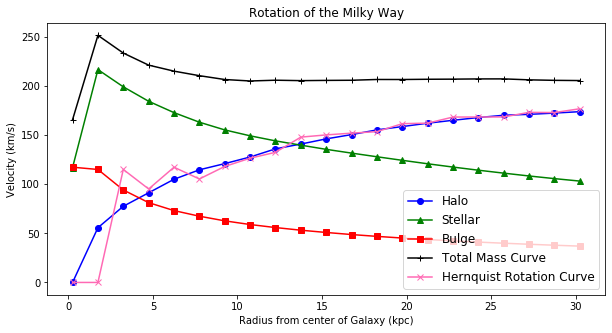

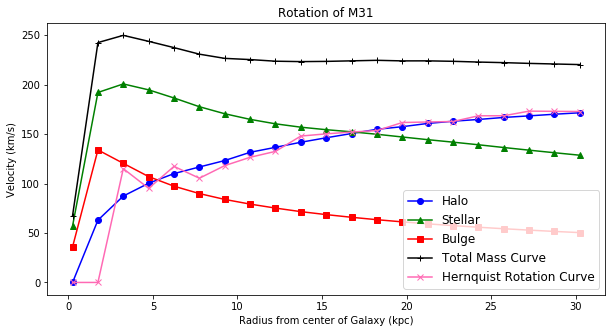

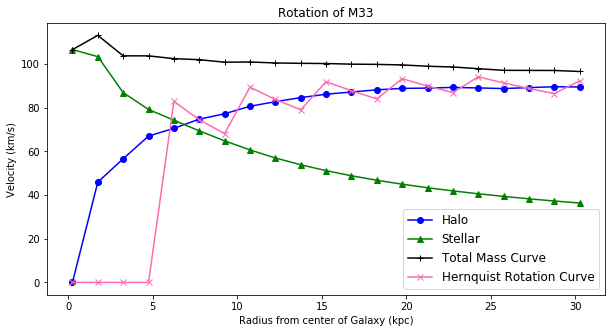

In [6]:
### Milky Way ###

#plot the rotation curve of each galaxy, using given radius array from Hw

#initailize the class at snapschot 0
MW = MW.MassProfile = MassProfile("MW",0)
#radius array
r = np.arange(0.25,30.5,1.5)*u.kpc
#setting figure size
plt.figure(figsize=(10,5))
#plotting the rotation curve by particle type 
plt.plot(r,MW.CircularVelocity(1,r),marker = 'o',color = 'blue',label = 'Halo')
plt.plot(r,MW.CircularVelocity(2,r),marker = '^',color = 'green',label = 'Stellar') #stellar
plt.plot(r,MW.CircularVelocity(3,r),marker = 's',color = 'red',label = 'Bulge') #bulge
#plotting the total rotation curve
plt.plot(r,MW.CircularVelocityTotal(r),marker = '+', color = 'black', label = 'Total Mass Curve')
#plotting rotation curve based on Hernquist Profile
plt.plot(r,MW.HernquistVCirc(r/u.kpc,61.1,1.97),marker = 'x',color='hotpink',label = 'Hernquist Rotation Curve')
#labels
plt.xlabel('Radius from center of Galaxy (kpc)')
plt.ylabel('Velocity (km/s)')
plt.title('Rotation of the Milky Way')
# Legend
plt.legend(loc='lower right',fontsize='large')

plt.show()



### M31 ###
M31 = M31.MassProfile = MassProfile("M31",0)
#radius array
r = np.arange(0.25,30.5,1.5)*u.kpc
#setting figure size
plt.figure(figsize=(10,5))
#plotting the rotation curve by particle type 
plt.plot(r,M31.CircularVelocity(1,r),marker = 'o',color = 'blue',label = 'Halo')
plt.plot(r,M31.CircularVelocity(2,r),marker = '^',color = 'green',label = 'Stellar') #stellar
plt.plot(r,M31.CircularVelocity(3,r),marker = 's',color = 'red',label = 'Bulge') #bulge
#plotting the total rotation curve
plt.plot(r,M31.CircularVelocityTotal(r),marker = '+', color = 'black', label = 'Total Mass Curve')
#plotting rotation curve based on Hernquist Profile
plt.plot(r,M31.HernquistVCirc(r/u.kpc,60.2,1.92),marker = 'x',color='hotpink',label = 'Hernquist Rotation Curve')
#labels
plt.xlabel('Radius from center of Galaxy (kpc)')
plt.ylabel('Velocity (km/s)')
plt.title('Rotation of M31')
# Legend
plt.legend(loc='lower right',fontsize='large')

plt.show()



### M33 ### 
M33 = M33.MassProfile = MassProfile("M33",0)
#radius array
r = np.arange(0.25,30.5,1.5)*u.kpc
#setting figure size
plt.figure(figsize=(10,5))
#plotting the rotation curve by particle type 
plt.plot(r,M33.CircularVelocity(1,r),marker = 'o',color = 'blue',label = 'Halo')
plt.plot(r,M33.CircularVelocity(2,r),marker = '^',color = 'green',label = 'Stellar') #stellar
#plotting the total rotation curve
plt.plot(r,M33.CircularVelocityTotal(r),marker = '+', color = 'black', label = 'Total Mass Curve')
#plotting rotation curve based on Hernquist Profile
plt.plot(r,M33.HernquistVCirc(r/u.kpc,25,0.19),marker = 'x',color='hotpink',label = 'Hernquist Rotation Curve')
#labels
plt.xlabel('Radius from center of Galaxy (kpc)')
plt.ylabel('Velocity (km/s)')
plt.title('Rotation of M33')
# Legend
plt.legend(loc='lower right',fontsize='large')

plt.show()